### Favourite Grocery Sales Forecasting

We will be predicting the unit sales for thousands of items sold at different Favorita stores located in Ecuador. The training data includes dates, store and item information, whether that item was being promoted, as well as the unit sales. Additional files include supplementary information that may be useful in building your models.

- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

We also notice that there are a small number of items seen in the training data that aren't seen in the test data. (We are thinking of how to manage that situation, maybe remove it?)

We don’t know the reason of zero sales for a item in a particular store is because it was out of stock or the store did not intend to sell that item in the first place. As a result, we were asked to predict unit sales for every possible (store, item, date) combination in the test period, without knowing if an item was even on display. Also, we have no idea if new items were rolled out to all stores at once or there were more sophisticated strategies.

In [315]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import math
import pandas as pd
import numpy as np
from datetime import datetime

# Charting libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models.tools import HoverTool

hover = HoverTool()
output_notebook()

from helpers import readfile

Loading BokehJS ...

In [2]:
os.getcwd()

'/Users/terencelim/Documents/datascience/3102'

## Overall Datasets Stats

### Stores Data

In [10]:
stores_df = readfile('data', 'stores.csv')
print(f'Stores DataFrame consists of {len(stores_df)} rows.\nNull values summary: \n{stores_df.isnull().sum()}')
stores_df.describe()

Stores DataFrame consists of 54 rows.
Null values summary: 
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


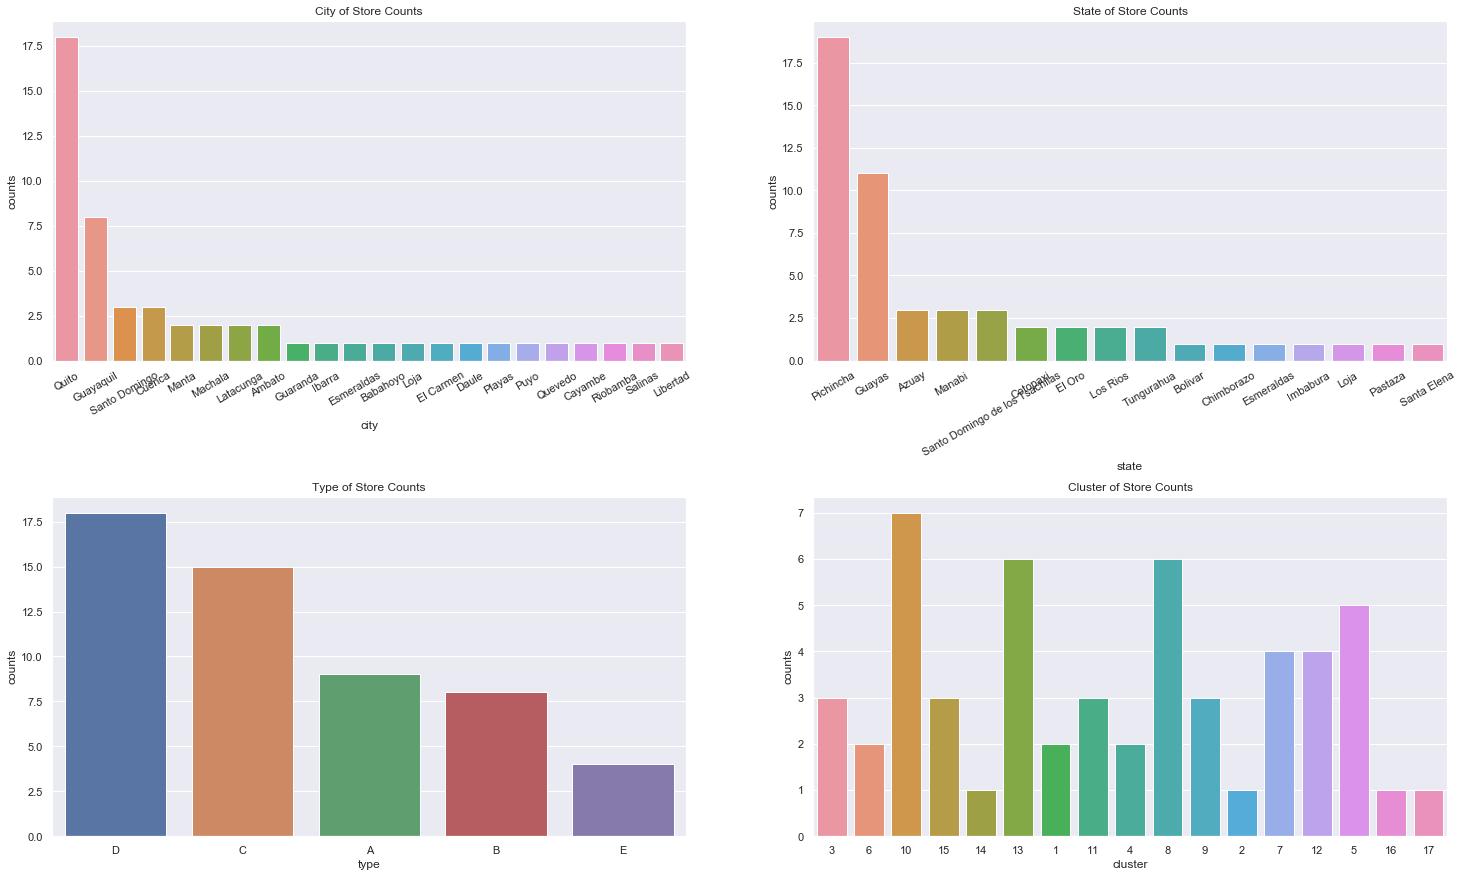

In [325]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25,15))
matplotlib.pyplot.subplots_adjust(wspace=0.2, hspace=0.4)

store_result1 = stores_df.groupby(['city']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
store_chart1 = sns.barplot(x='city', y='counts', data=store_result1, ax=axs[0,0])
_ = store_chart1.set_xticklabels(rotation=30, labels=store_result1['city'])
_ = store_chart1.set_title('City of Store Counts')

store_result2 = stores_df.groupby(['state']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
store_chart2 = sns.barplot(x='state', y='counts', data=store_result2, ax=axs[0,1])
_ = store_chart2.set_xticklabels(rotation=30, labels=store_result2['state'])
_ = store_chart2.set_title('State of Store Counts')

store_result3 = stores_df.groupby(['type']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
store_chart3 = sns.barplot(x='type', y='counts', data=store_result3, ax=axs[1,0])
_ = store_chart3.set_xticklabels(labels=store_result3['type'])
_ = store_chart3.set_title('Type of Store Counts')

store_result4 = stores_df.groupby(['cluster']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
store_chart4 = sns.barplot(x='cluster', y='counts', data=store_result4, ax=axs[1,1])
_ = store_chart4.set_xticklabels(labels=store_result4['cluster'])
_ = store_chart4.set_title('Cluster of Store Counts')

City and State charts show similar values since city->state have 1:1 mapping.<br>
Cluster is a grouping of similar stores.

### Items Data

In [11]:
items_df = readfile('data', 'items.csv')
print(f'Items DataFrame consists of {len(items_df)} rows.\nNull values summary: \n{items_df.isnull().sum()}')
items_df.describe()

Stores DataFrame consists of 4100 rows.
Null values summary: 
item_nbr      0
family        0
class         0
perishable    0
dtype: int64


,item_nbr,class,perishable
count,4.100000e+03,4100.0000,4100.000000
mean,1.251436e+06,2169.6500,0.240488
std,5.876872e+05,1484.9109,0.427432
min,9.699500e+04,1002.0000,0.000000
25%,8.181108e+05,1068.0000,0.000000
50%,1.306198e+06,2004.0000,0.000000
75%,1.904918e+06,2990.5000,0.000000
max,2.134244e+06,7780.0000,1.000000


In [123]:
items_df.head(5)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


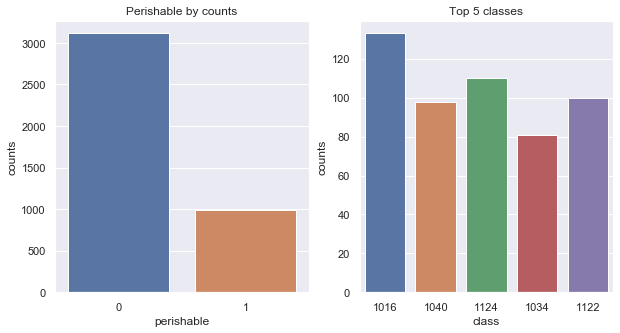

In [212]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
matplotlib.pyplot.subplots_adjust(wspace=0.2, hspace=0.4)

item_result1 = items_df.groupby(['perishable']).size().reset_index(name='counts')
item_chart1 = sns.barplot(x='perishable', y='counts', data=item_result1, ax=axs[0])
_ = item_chart1.set_xticklabels(labels=item_result1['perishable'])
_ = item_chart1.set_title('Perishable by counts')

item_result2 = items_df.groupby(['class']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
item_result2 = item_result2.head()
item_chart2 = sns.barplot(x='class', y='counts', data=item_result2, ax=axs[1])
_ = item_chart2.set_xticklabels(labels=item_result2['class'])
_ = item_chart2.set_title('Top 5 classes')

In [210]:
hover.tooltips = """
    <div>
        <h3>@x</h3>
        <div><strong>Count: </strong>@top</div>    
    </div>
"""
item_result4 = items_df.groupby(['family']).size().reset_index(name='counts').sort_values(
    by='counts', ascending=False)
x_val = list(str(val) for val in item_result4['family'].values)
y_val = list(str(val) for val in item_result4['counts'].values)

p = figure(x_range=x_val, plot_height=350, plot_width=800, x_axis_label = 'Family', title="Family Counts")

p.vbar(x=x_val, top=y_val, width=0.9)

p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = math.pi/2
p.y_range.start = 0
p.add_tools(hover)

show(p)

### Oil Data

In [316]:
oil_df = readfile('data', 'oil.csv')
print(f'Oil DataFrame consists of {len(oil_df)} rows.\nNull values summary: \n{oil_df.isnull().sum()}')
oil_df.describe()

Oil DataFrame consists of 1218 rows.
Null values summary: 
date           0
dcoilwtico    43
dtype: int64


,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [312]:
hover.tooltips = """
    <div>
        <h3>@x</h3>
        <div><strong>Price: $</strong>@y</div>    
    </div>
"""
# x_val = [(datetime.strptime(val, '%Y-%M-%d')).date() for val in oil_df['date'].values]
x_val = [val for val in oil_df['date'].values]
y_val = list(str(val) for val in oil_df['dcoilwtico'].values)

p = figure(x_range=x_val, plot_height=350, plot_width=1000, x_axis_label='Date', y_axis_label='Oil Price', title="Oil Price over Time")

p.line(x=oil_df['date'], y=oil_df['dcoilwtico'])

p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = math.pi/2
p.y_range.start = 0
p.add_tools(hover)

show(p)

Oil prices seemed to drop starkly in the second half of 2014.<br>
Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.

To consider:<br>
<b>Did fall in oil prices affect consumers buying behaviour in Grocery stores?</b>

### Transactions Data

In [13]:
transactions_df = readfile('data', 'transactions.csv')
print(f'Transactions DataFrame consists of {len(transactions_df)} rows.\nNull values summary: \n{transactions_df.isnull().sum()}')
transactions_df.describe()

Transactions DataFrame consists of 83488 rows.
Null values summary: 
date            0
store_nbr       0
transactions    0
dtype: int64


,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


In [326]:
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


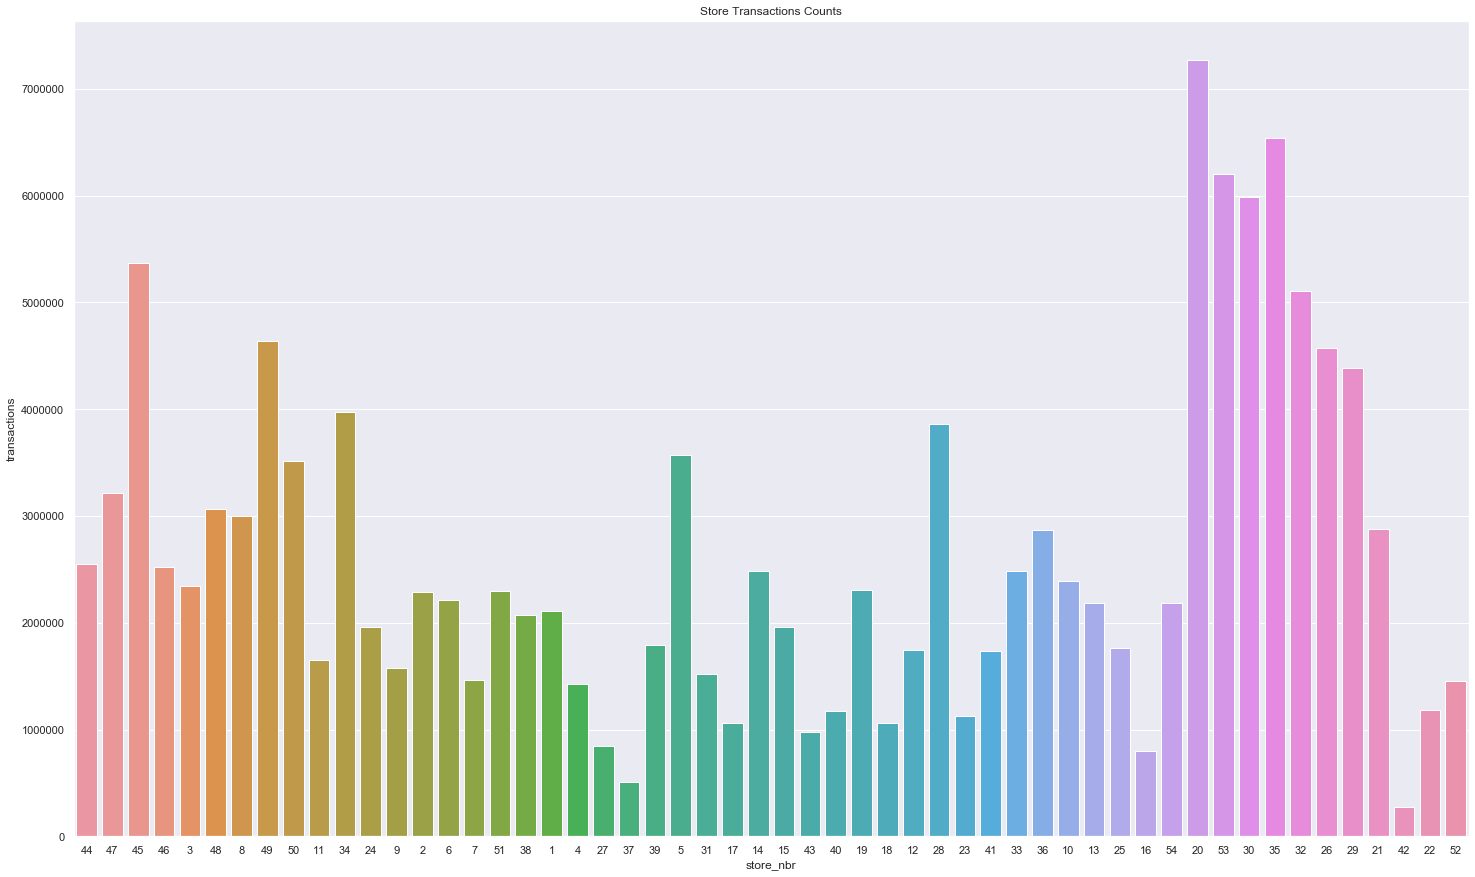

In [343]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
matplotlib.pyplot.subplots_adjust(wspace=0.2, hspace=0.4)

transactions_result2 = transactions_df.groupby(['store_nbr']).sum()[['transactions']].reset_index().sort_values(by='transactions', ascending=False)
transactions_chart2 = sns.barplot(x='store_nbr', y='transactions', data=transactions_result2)
_ = transactions_chart2.set_xticklabels(labels=transactions_result2['store_nbr'])
_ = transactions_chart2.set_title('Store Transactions Counts')

In [313]:
hover.tooltips = """
    <div>
        <h3>@x</h3>
        <div><strong>Count: </strong>@y</div>    
    </div>
"""
transactions_result1 = transactions_df.groupby('date').sum()[['transactions']].reset_index()
x_val = [str(val) for val in transactions_result1['date'].values]
y_val = list(str(val) for val in transactions_result1['transactions'].values)

p = figure(x_range=x_val, plot_height=350, plot_width=1000, x_axis_label='Date', y_axis_label='Transaction Count', title="Transaction Count over Time")

p.line(x=x_val, y=y_val)

p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = math.pi/2
p.y_range.start = 0
p.add_tools(hover)

show(p)

Transaction count on 1st January of every year is really low, which is no surprising since shops may close early.

### Holiday Events Data

In [15]:
holiday_events_df = readfile('data', 'holidays_events.csv')
print(f'Holiday Events DataFrame consists of {len(holiday_events_df)} \
      rows.\nNull values summary: \n{holiday_events_df.isnull().sum()}')
holiday_events_df.describe()

Holiday Events DataFrame consists of 350       rows.
Null values summary: 
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338


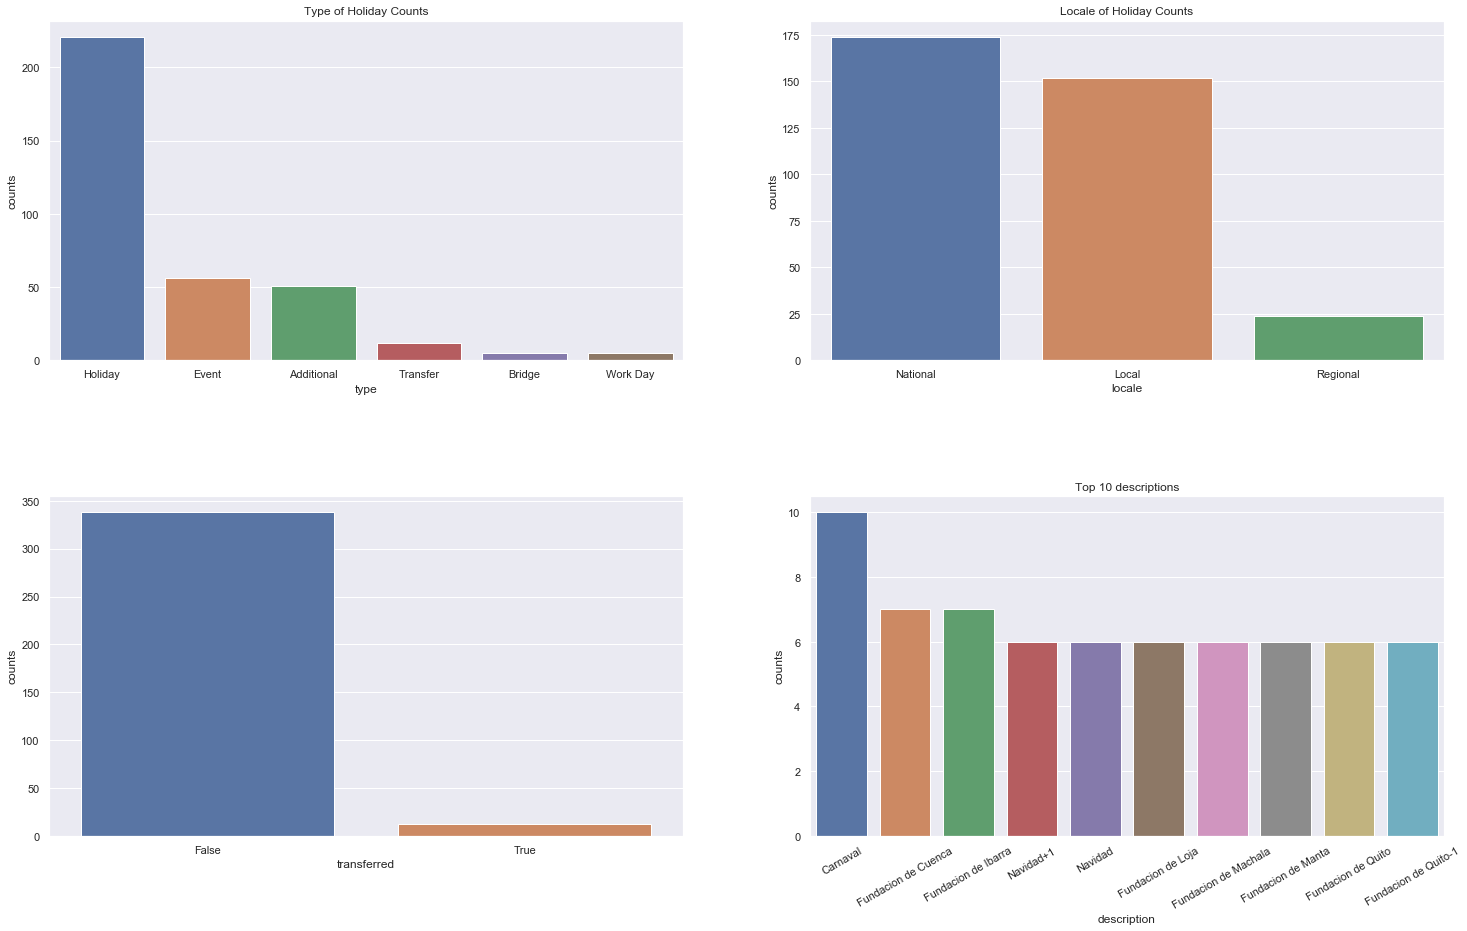

In [324]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25,15))
matplotlib.pyplot.subplots_adjust(wspace=0.2, hspace=0.4)

holidayevents_result1 = holiday_events_df.groupby(['type']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
holidayevents_chart1 = sns.barplot(x='type', y='counts', data=holidayevents_result1, ax=axs[0,0])
_ = holidayevents_chart1.set_xticklabels(labels=holidayevents_result1['type'])
_ = holidayevents_chart1.set_title('Type of Holiday Counts')

holidayevents_result2 = holiday_events_df.groupby(['locale']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
holidayevents_chart2 = sns.barplot(x='locale', y='counts', data=holidayevents_result2, ax=axs[0,1])
_ = holidayevents_chart2.set_xticklabels(labels=holidayevents_result2['locale'])
_ = holidayevents_chart2.set_title('Locale of Holiday Counts')

holidayevents_result3 = holiday_events_df.groupby(['transferred']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
holidayevents_chart3 = sns.barplot(x='transferred', y='counts', data=holidayevents_result3, ax=axs[1,0])
_ = holidayevents_chart4.set_xticklabels(labels=holidayevents_result3['transferred'])
_ = holidayevents_chart4.set_title('Transferred Holiday Counts')

holidayevents_result4 = holiday_events_df.groupby(['description']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
holidayevents_result4 = holidayevents_result4.head(10)
holidayevents_chart4 = sns.barplot(x='description', y='counts', data=holidayevents_result4, ax=axs[1,1])
_ = holidayevents_chart4.set_xticklabels(rotation=30, labels=holidayevents_result4['description'])
_ = holidayevents_chart4.set_title('Top 10 descriptions')

### Train Data

In [16]:
train_df = readfile('data', 'train.csv')
print(f'Train DataFrame consists of {len(train_df)} rows.\nNull values summary: \n{train_df.isnull().sum()}')
train_df.describe()

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Train Events DataFrame consists of 125497040 rows.
Null values summary: 
id                    0
date                  0
store_nbr             0
item_nbr              0
unit_sales            0
onpromotion    21657651
dtype: int64


,id,store_nbr,item_nbr,unit_sales
count,1.254970e+08,1.254970e+08,1.254970e+08,1.254970e+08
mean,6.274852e+07,2.746458e+01,9.727692e+05,8.554865e+00
std,3.622788e+07,1.633051e+01,5.205336e+05,2.360515e+01
min,0.000000e+00,1.000000e+00,9.699500e+04,-1.537200e+04
25%,3.137426e+07,1.200000e+01,5.223830e+05,2.000000e+00
50%,6.274852e+07,2.800000e+01,9.595000e+05,4.000000e+00
75%,9.412278e+07,4.300000e+01,1.354380e+06,9.000000e+00
max,1.254970e+08,5.400000e+01,2.127114e+06,8.944000e+04


In [18]:
min_date, max_date = min(train_df['date']), max(train_df['date'])
print(f'Train DataFrame consists of data from {min_date} to {max_date}')

Train DataFrame consists of data from 2013-01-01 to 2017-08-15


In [355]:
hover.tooltips = """
    <div>
        <h3><strong>Store: </strong>@x</h3>
        <div><strong>Count: </strong>@top</div>    
    </div>
"""
train_result1 = train_df.groupby(['store_nbr']).size().reset_index(
    name='counts').sort_values(by='counts', ascending=False)
x_val = list(str(val) for val in train_result1['store_nbr'].values)
y_val = list(str(val) for val in train_result1['counts'].values)

p = figure(x_range=x_val, plot_height=350, plot_width=800, x_axis_label = 'Store Sales', title="Store Sales Counts")

p.vbar(x=x_val, top=y_val, width=0.9)

p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = math.pi/2
p.y_range.start = 0
p.add_tools(hover)

show(p)

GlyphRenderer(id='55721', ...)

In [362]:
hover.tooltips = """
    <div>
        <h3><strong>Item: </strong>@x</h3>
        <div><strong>Count: </strong>@top</div>    
    </div>
"""
train_result2 = train_df.groupby(['item_nbr']).size().reset_index(
    name='counts').sort_values(by='counts', ascending=False)
x_val = list(str(val) for val in train_result2['item_nbr'].values)
y_val = list(str(val) for val in train_result2['counts'].values)

p = figure(x_range=x_val, plot_height=350, plot_width=1000, x_axis_label = 'Item Sales', title="Item Sales Counts")

p.vbar(x=x_val, top=y_val, width=0.9)

p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = math.pi/2
p.y_range.start = 0
p.add_tools(hover)

show(p)

GlyphRenderer(id='57987', ...)

### Test Data

In [19]:
test_df = readfile('data', 'test.csv')
print(f'Test DataFrame consists of {len(test_df)} rows.\nNull values summary: \n{test_df.isnull().sum()}')
test_df.describe()

Test DataFrame consists of 3370464 rows.
Null values summary: 
id             0
date           0
store_nbr      0
item_nbr       0
onpromotion    0
dtype: int64


,id,store_nbr,item_nbr
count,3.370464e+06,3.370464e+06,3.370464e+06
mean,1.271823e+08,2.750000e+01,1.244798e+06
std,9.729693e+05,1.558579e+01,5.898362e+05
min,1.254970e+08,1.000000e+00,9.699500e+04
25%,1.263397e+08,1.400000e+01,8.053210e+05
50%,1.271823e+08,2.750000e+01,1.294665e+06
75%,1.280249e+08,4.100000e+01,1.730015e+06
max,1.288675e+08,5.400000e+01,2.134244e+06
